# Consistency Test

To demonstrate the consistency of the different noise simulation methods, we
calculate the impact of white noise with the Monte Carlo method, a Lindblad
master equation and generalized filter functions.

The qubit under consideration is a singlet-triplet semiconductor qubit with
the Hamiltonian:

\begin{equation}
H = \frac{J + \delta J}{2}\sigma_z + E_z \sigma_x
\end{equation}

where $J$ is the exchange energy, $E_z$ the zeeman-splitting and $\delta J$ is
white noise.

We start without additional control $J=0$ and create helper functions for the
calculation of infidelities with various methods.

In [1]:
from qopt import *
import numpy as np
import matplotlib.pyplot as plt


def create_lindblad_solver(n_time_steps, noise_variance, total_time,
                           bz_rotation):
    delta_bz = bz_rotation / total_time
    delta_t = total_time / n_time_steps

    def prefactor_function(transferred_parameters, _):
        return noise_variance * np.ones_like(transferred_parameters)

    lindblad_solver = LindbladSolver(
        h_drift=[delta_bz * .5 * DenseOperator.pauli_x()],
        h_ctrl=[.5 * DenseOperator.pauli_z()],
        tau=delta_t * np.ones(n_time_steps),
        prefactor_function=prefactor_function,
        lindblad_operators=[.5 * DenseOperator.pauli_z()]
    )
    return lindblad_solver

def evaluate_infidelity_fid_lindblad(n_time_steps, noise_variance,
                                     total_time, bz_rotation):
    lindblad_solver = create_lindblad_solver(
        n_time_steps, noise_variance, total_time, bz_rotation)

    fid_ctrl_amps = np.expand_dims(np.zeros(n_time_steps), 1)
    target = (.5 * DenseOperator.pauli_x()).exp(1j * bz_rotation)
    lindblad_cost_fkt = OperationInfidelity(
        solver=lindblad_solver,
        super_operator_formalism=True,
        target=target
    )
    lindblad_solver.set_optimization_parameters(fid_ctrl_amps)

    return lindblad_cost_fkt.costs()

def create_mc_solver(n_time_steps, noise_variance, total_time, bz_rotation,
                     low_freq_ex):
    delta_bz = bz_rotation / total_time
    delta_t = total_time / n_time_steps


    def noise_spectral_density(f):
        return 2 * noise_variance * np.ones_like(f)  # factor of 2 for
        # one-sided spectrum

    noise_trace_generator = NTGColoredNoise(
        n_samples_per_trace=n_time_steps,
        dt=delta_t,
        noise_spectral_density=noise_spectral_density,
        n_traces=1000,
        low_frequency_extension_ratio=low_freq_ex
    )
    # The low frequency extension leads to the sampling of a noise trace
    # for more time steps. The simulation then uses only a section of this
    # longer trace. The extension allows the noise trace generator to include
    # low frequency noise.

    monte_carlo_solver = SchroedingerSMonteCarlo(
        h_drift=[delta_bz * .5 * DenseOperator.pauli_x()],
        h_ctrl=[.5 * DenseOperator.pauli_z()],
        tau=delta_t * np.ones(n_time_steps),
        h_noise=[.5 * DenseOperator.pauli_z()],
        noise_trace_generator=noise_trace_generator
    )

    return monte_carlo_solver


def evaluate_fidelity_fid_mc(
        n_time_steps, noise_variance, total_time, bz_rotation, low_freq_rel):
    monte_carlo_solver = create_mc_solver(
        n_time_steps, noise_variance, total_time, bz_rotation, low_freq_rel)
    fid_ctrl_amps = np.expand_dims(np.zeros(n_time_steps), 1)
    target = (.5 * DenseOperator.pauli_x()).exp(1j * bz_rotation)

    mc_cost_fkt = OperationNoiseInfidelity(
        solver=monte_carlo_solver,
        target=target,
        neglect_systematic_errors=False
    )

    monte_carlo_solver.set_optimization_parameters(fid_ctrl_amps)
    return mc_cost_fkt.costs()

def create_ff_solver(n_time_steps, total_time, bz_rotation):
    delta_bz = bz_rotation / total_time
    delta_t = total_time / n_time_steps

    ff_hamiltonian_noise =[[
        .5 * DenseOperator.pauli_z().data,
        np.ones(n_time_steps),
        'noise Source 1'
    ], ]

    ff_solver = SchroedingerSolver(
        h_drift=[delta_bz * .5 * DenseOperator.pauli_x()],
        h_ctrl=[.5 * DenseOperator.pauli_z()],
        tau=delta_t * np.ones(n_time_steps),
        filter_function_h_n=ff_hamiltonian_noise
    )
    return ff_solver

def evaluate_ff_infid(n_time_steps, noise_variance, total_time, bz_rotation,
                      low_freq_rel):

    ff_solver = create_ff_solver(n_time_steps, total_time, bz_rotation)
    fid_ctrl_amps = np.expand_dims(np.zeros(n_time_steps), 1)
    def noise_spectral_density(f):
        return 2 * noise_variance * np.ones_like(f)  # factor of 2 for
        # one-sided spectrum
    ff_cost_fkn = OperatorFilterFunctionInfidelity(
        solver=ff_solver,
        noise_power_spec_density=noise_spectral_density,
        omega=(1 / (total_time * low_freq_rel)) *
              (np.arange(n_time_steps * low_freq_rel) + 1)
    )
    ff_solver.set_optimization_parameters(fid_ctrl_amps)
    return ff_cost_fkn.costs()

We calculate the infidelities as function of the noise strength.

In [2]:
total_time = 2
n_variance_values = 15
noise_variance_values = np.logspace(
    -4, -1, n_variance_values, dtype=float, endpoint=True, base=10)
mc_infidelities = np.zeros(n_variance_values)
lindblad_infidelities = np.zeros(n_variance_values)
ff_infidelities = np.zeros(n_variance_values)

for i, noise_variance in enumerate(noise_variance_values):
    lindblad_infidelities[i] = evaluate_infidelity_fid_lindblad(
        n_time_steps=30, noise_variance=noise_variance, total_time=total_time,
        bz_rotation=np.pi
    )
    mc_infidelities[i] = evaluate_fidelity_fid_mc(
        n_time_steps=30, noise_variance=noise_variance, total_time=total_time,
        bz_rotation=np.pi, low_freq_rel=10)
    ff_infidelities[i] = evaluate_ff_infid(
        n_time_steps=30, noise_variance=noise_variance, total_time=total_time,
        bz_rotation=np.pi, low_freq_rel=10
    )

Plotting the infidelities reveals that the results only deviate by a few
percent.

Text(0.5, 0, 'Noise Spectral Density (a.u.)')

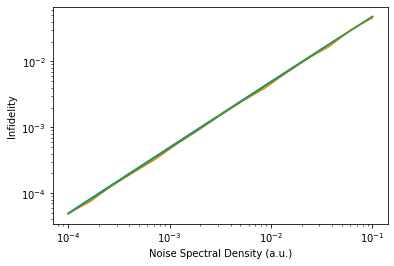

In [3]:
plt.plot(noise_variance_values, lindblad_infidelities, label='Lindblad')
plt.plot(noise_variance_values, mc_infidelities, label='Monte Carlo')
plt.plot(noise_variance_values, ff_infidelities, label='Filter Functions')
plt.xscale('log')
plt.ylabel('Infidelity')
plt.yscale('log')
plt.xlabel('Noise Spectral Density (a.u.)')